# Feature Engineering

Feature engineering is one of **the most important** task in a analysis project. So let's do it in R. You can summarise _feature engineering_ with understanding your data and find new (or combined, or edited) variables that can help the ML algorithm to be more precise.

#### first get our data

In [1]:
train <- read.csv('train.csv')
test<- read.csv('test.csv')

In [2]:
str(train)

'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


How about Name, Cabin, or Ticket? Is there more information in the strings?

In [3]:
train$Name[318:321] # ok, print the first 4 entries

[1] Moraweck, Dr. Ernest                                    
[2] Wick, Miss. Mary Natalie                                
[3] Spedden, Mrs. Frederic Oakley (Margaretta Corning Stone)
[4] Dennis, Mr. Samuel                                      
891 Levels: Abbing, Mr. Anthony ... Zimmerman, Mr. Leo

Found titles immediately: Mr, Mrs, Miss, Master, Rev., Dr.,...

Let's create a new feature, _Title_, for the test and training sample. We use the same format of the strings to edit 'em in one go.

#### Merge the two datasets
When bot datasets have the same columns, we can use `rbind`. 

In [4]:
test$Survived <- NA
comb_data <- rbind(train, test)

In [5]:
comb_data$Name <- as.character(comb_data$Name) # transform factor into string variable
str(comb_data$Name)

 chr [1:1309] "Braund, Mr. Owen Harris" ...


Now the _Name_ variable is just string format.

We use the _Name**,** Title**.**_ as a way to split the strings

In [6]:
strsplit(comb_data$Name[1:3], split='[,.]')[[1]][2]

[1] " Mr"

This worked. How to get it working on full columns? `sapply` (apply function over a list/vector) will help. There are different `apply` functions for different use cases.

In [7]:
comb_data$Title <- sapply(comb_data$Name,
                         FUN=function(x){strsplit(x,split='[,.]')[[1]][2]})

In [8]:
comb_data$Title[318:321] # yes, this worked

[1] " Dr"   " Miss" " Mrs"  " Mr"

There are some spaces in front of the titles, let's get rid of 'em.

In [9]:
comb_data$Title <- sub(' ','',comb_data$Title)

In [10]:
table(comb_data$Title)



        Capt          Col          Don         Dona           Dr     Jonkheer 
           1            4            1            1            8            1 
        Lady        Major       Master         Miss         Mlle          Mme 
           1            2           61          260            2            1 
          Mr          Mrs           Ms          Rev          Sir the Countess 
         757          197            2            8            1            1 

#### Create new feature variable from Title
We'll group a couple of titles to get more meaningful categories

In [11]:
comb_data$Title[ comb_data$Title=='Don'] <- 'Mr'

In [12]:
comb_data$Title[ comb_data$Title %in% c('Dona','Mme')] <- 'Mrs'
comb_data$Title[ comb_data$Title %in% c('Mlle','Ms')] <- 'Miss'
comb_data$Title[ comb_data$Title %in% c('Col','Capt','Major')] <- 'Millitary'
comb_data$Title[ comb_data$Title %in% c('Sir', 'Dr', 
                                        'Jonkheer', 'Rev')] <- 'Sir'
comb_data$Title[ comb_data$Title %in% c('the Countess','Lady', 'Jonkvrouw')] <- 'Lady'

In [13]:
table(comb_data$Title)


     Lady    Master Millitary      Miss        Mr       Mrs       Sir 
        2        61         7       264       758       199        18 

Change the title to a category variable

In [14]:
comb_data$Title <- factor(comb_data$Title)

#### Create new feature based on siblings and parents
Add up children, parents, siblings and the passenger itself to family size.

In [15]:
comb_data$FamilySize <- comb_data$SibSp + comb_data$Parch + 1

We can also convert tables to data frames...

In [16]:
fsDF <- data.frame(table(comb_data$FamilySize))

In [17]:
head(fsDF) # access colums: fsDF$Var1, fsDF$Freq

,Var1,Freq
1,1,790
2,2,235
3,3,159
4,4,43
5,5,22
6,6,25


#### Split data back into training and testing datasets

In [18]:
train <- comb_data[1:891,]
test <- comb_data[892:1309,]

The comma after the slice indices denote that we'd like to have all columns availble

In [19]:
head(train,1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S,Mr,2


In [21]:
library(rpart)
library(RColorBrewer)
library(rpart.plot)
library(rattle)

Rattle: A free graphical interface for data mining with R.
Version 4.1.0 Copyright (c) 2006-2015 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.


In [23]:
decTree <- rpart( Survived ~ Sex + Age + Fare + Pclass + FamilySize + Title + Embarked,
                data = train, method = 'class')

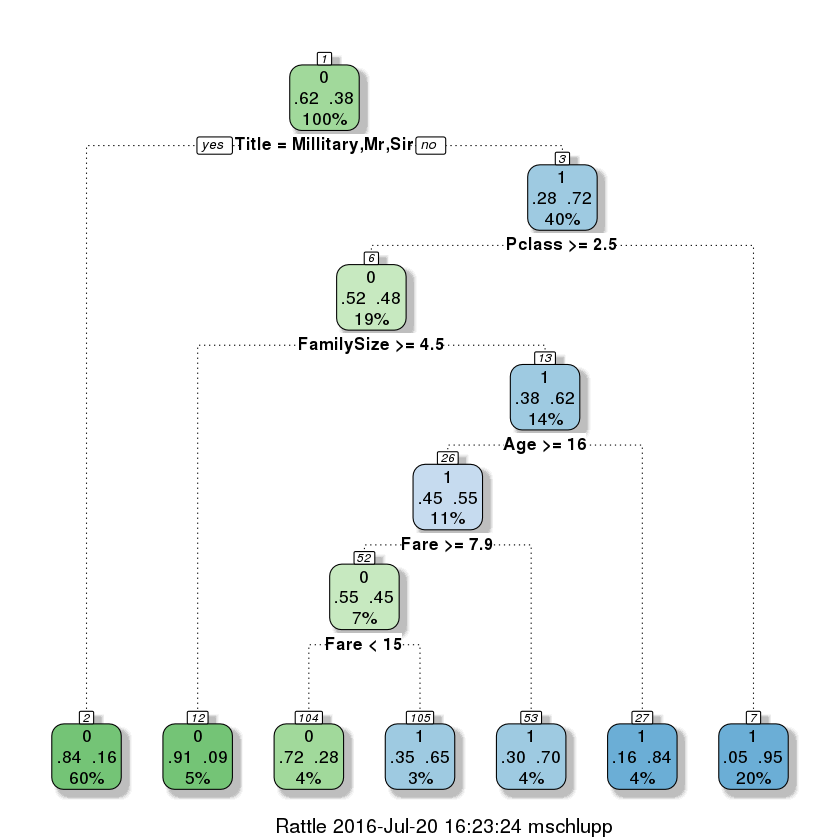

In [24]:
fancyRpartPlot(decTree)

### Predict a solution with this new tree

In [41]:
prediction <- predict(decTree, test, type='class')

In [43]:
test$Survived <- prediction

In [63]:
solution <- data.frame(PassengerId=test$PassengerId, Survived=test$Survived)

In [65]:
write.csv(solution, "solution.csv", row.names=FALSE)

In [58]:
?write.csv2

write.table {utils},R Documentation
x,"the object to be written, preferably a matrix or data frame. If not, it is attempted to coerce x to a data frame."
file,"either a character string naming a file or a connection open for writing. """" indicates output to the console."
append,"logical. Only relevant if file is a character string. If TRUE, the output is appended to the file. If FALSE, any existing file of the name is destroyed."
quote,"a logical value (TRUE or FALSE) or a numeric vector. If TRUE, any character or factor columns will be surrounded by double quotes. If a numeric vector, its elements are taken as the indices of columns to quote. In both cases, row and column names are quoted if they are written. If FALSE, nothing is quoted."
sep,the field separator string. Values within each row of x are separated by this string.
eol,"the character(s) to print at the end of each line (row). For example, eol = ""\r\n"" will produce Windows' line endings on a Unix-alike OS, and eol = ""\r"" will produce files as expected by Excel:mac 2004."
na,the string to use for missing values in the data.
dec,the string to use for decimal points in numeric or complex columns: must be a single character.
row.names,"either a logical value indicating whether the row names of x are to be written along with x, or a character vector of row names to be written."
col.names,"either a logical value indicating whether the column names of x are to be written along with x, or a character vector of column names to be written. See the section on ‘CSV files’ for the meaning of col.names = NA."
